# NC Pediatric Access Desert Analysis
## Mapping the Gap Between Referral and Care

**Author:** John Apel | M.S. Applied Data Science, Syracuse University

Children with complex medical needs are routinely referred to pediatric specialists like neurologists, developmental pediatricians, therapists, cardiologists. But a referral is not care. Between the moment a referral is placed and the moment a child is actually seen, there is a gap that no system owns. Wait times stretch months. Cancellations go unfilled. Families shoulder the coordination burden alone. Developmental windows close in silence.

This analysis quantifies that gap for North Carolina by mapping pediatric specialist supply against child population demand across all 100 NC counties to answer three questions:

1. **Where are the pediatric specialists?** (Supply — NPI Registry)
2. **Where are the children who need them?** (Demand — Census ACS)
3. **Where do supply and demand diverge most severely?** (Access Ratio Analysis)

The analysis includes a focused deep dive into the 18-county Western North Carolina region, where a pilot program for pediatric access infrastructure is being designed.

**Data Sources:**
- CMS National Provider Identifier (NPI) Registry — provider locations by specialty
- U.S. Census Bureau American Community Survey (2022) — child population, poverty rates
- Census TIGER/Line — county boundary shapefiles
- Census ZCTA-County Crosswalk — ZIP code to county mapping


In [ ]:
# ============================================================
# NC Pediatric Access Desert Analysis
# Step 1: Pediatric Specialist Supply (NLM Clinical Tables API)
# ============================================================


# --- Cell 1: Setup ---

!pip install geopandas folium mapclassify -q

import pandas as pd
import numpy as np
import requests
import time
import json
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages installed and imported")

✅ Packages installed and imported


---
## Step 1: Pediatric Specialist Supply

### Defining the Specialties

The specialties tracked in this analysis map directly to the referral types identified in pediatric care coordination: neurology, PT/OT/SLP, developmental pediatrics, cardiology, behavioral health, audiology, ENT, and vision. Each specialty is identified by its Healthcare Provider Taxonomy Code, a standardized classification maintained by the National Uniform Claim Committee (NUCC).

We use pediatric-specific taxonomy codes where they exist (e.g., Pediatric Physical Therapist rather than all Physical Therapists) to avoid inflating counts with providers who don't serve children.


In [ ]:


# --- Cell 2: Define pediatric specialty taxonomy codes ---

# These map directly to the specialties in the business plan.
# Source: https://taxonomy.nucc.org/

PEDIATRIC_TAXONOMIES = {
    # Pediatric Neurology
    '2084N0402X': 'Child Neurology',
    '2084P0005X': 'Neurodevelopmental Disabilities',

    # PT / OT / SLP (pediatric-specific codes to avoid pulling ALL PTs)
    '2251P0200X': 'Pediatric Physical Therapist',
    '2255P0200X': 'Pediatric Occupational Therapist',
    '235Z00000X': 'Speech-Language Pathologist',

    # Developmental Pediatrics
    '2080P0006X': 'Developmental-Behavioral Pediatrics',

    # Cardiology
    '2080P0201X': 'Pediatric Cardiology',

    # Behavioral Health
    '101YP0004X': 'Child/Adolescent Psychologist',
    '2084P0804X': 'Child & Adolescent Psychiatry',

    # Audiology
    '231H00000X': 'Audiologist',

    # ENT
    '207YS0123X': 'Pediatric Otolaryngology',
    '207Y00000X': 'Otolaryngology',

    # Vision
    '207W00000X': 'Ophthalmology',
}

# Group into service categories matching the business plan
SERVICE_CATEGORIES = {
    'Pediatric Neurology': ['2084N0402X', '2084P0005X'],
    'PT/OT/SLP': ['2251P0200X', '2255P0200X', '235Z00000X'],
    'Developmental Pediatrics': ['2080P0006X'],
    'Pediatric Cardiology': ['2080P0201X'],
    'Behavioral Health': ['101YP0004X', '2084P0804X'],
    'Audiology': ['231H00000X'],
    'ENT': ['207YS0123X', '207Y00000X'],
    'Vision': ['207W00000X'],
}

print(f"Tracking {len(PEDIATRIC_TAXONOMIES)} taxonomy codes across {len(SERVICE_CATEGORIES)} service categories")


Tracking 13 taxonomy codes across 8 service categories


### Querying the NPI Registry

The NPPES API provides data on every registered healthcare provider in the United States. We query by taxonomy description and filter to NC, with pagination capped at 2,000 results per specialty to prevent timeout on broad categories like Speech-Language Pathology.

Each provider record includes their practice address, which we convert to a county using ZIP code crosswalks.


In [ ]:
# Replace Cell 3 and Cell 4 with this — paste into a single Colab cell

NPI_API = "https://npiregistry.cms.hhs.gov/api/"

def fetch_npi_providers(taxonomy_desc, state='NC', max_pages=10):
    """
    Fetch providers from NPPES API with hard pagination cap.
    """
    all_results = []
    limit = 200

    for page in range(max_pages):
        skip = page * limit
        params = {
            'version': '2.1',
            'state': state,
            'taxonomy_description': taxonomy_desc,
            'enumeration_type': 'NPI-1',
            'limit': limit,
            'skip': skip
        }

        try:
            resp = requests.get(NPI_API, params=params, timeout=30)
            resp.raise_for_status()
            data = resp.json()
            results = data.get('results', [])

            if not results:
                break

            all_results.extend(results)

            if len(results) < limit:
                break

            time.sleep(0.5)

        except Exception as e:
            print(f"    ❌ Page {page} error: {e}")
            break

    return all_results

def parse_npi_results(results, taxonomy_code, taxonomy_name):
    """Extract key fields from NPPES results."""
    providers = []
    for r in results:
        addresses = r.get('addresses', [])
        practice = next((a for a in addresses if a.get('address_purpose') == 'LOCATION'),
                       addresses[0] if addresses else {})

        providers.append({
            'npi': r.get('number', ''),
            'name': f"{r.get('basic',{}).get('first_name','')} {r.get('basic',{}).get('last_name','')}".strip(),
            'credential': r.get('basic', {}).get('credential', ''),
            'taxonomy_code': taxonomy_code,
            'taxonomy_name': taxonomy_name,
            'city': practice.get('city', ''),
            'state': practice.get('state', ''),
            'zip': str(practice.get('postal_code', ''))[:5],
        })
    return providers

# --- Query all specialties ---

# Use exact taxonomy descriptions the NPPES API recognizes
SEARCH_TERMS = {
    '2084N0402X': ('Child Neurology', 'Neurology'),
    '2084P0005X': ('Neurodevelopmental Disabilities', 'Neurodevelopmental'),
    '2251P0200X': ('Pediatric Physical Therapist', 'Pediatrics'),
    '2255P0200X': ('Pediatric Occupational Therapist', 'Pediatrics'),
    '235Z00000X': ('Speech-Language Pathologist', 'Speech'),
    '2080P0006X': ('Developmental-Behavioral Pediatrics', 'Developmental'),
    '2080P0201X': ('Pediatric Cardiology', 'Pediatric Cardiology'),
    '101YP0004X': ('Child/Adolescent Psychologist', 'Child'),
    '2084P0804X': ('Child & Adolescent Psychiatry', 'Child'),
    '231H00000X': ('Audiologist', 'Audiologist'),
    '207YS0123X': ('Pediatric Otolaryngology', 'Pediatric Otolaryngology'),
    '207Y00000X': ('Otolaryngology', 'Otolaryngology'),
    '207W00000X': ('Ophthalmology', 'Ophthalmology'),
}

print("⏳ Querying NPPES API for NC pediatric specialists...\n")

all_providers = []

for tax_code, (tax_name, search_term) in SEARCH_TERMS.items():
    results = fetch_npi_providers(search_term, state='NC', max_pages=10)
    providers = parse_npi_results(results, tax_code, tax_name)
    all_providers.extend(providers)
    print(f"  ✅ {tax_name:45s} {len(providers):>4} providers")
    time.sleep(1)

df_providers = pd.DataFrame(all_providers)
df_providers = df_providers[df_providers['state'] == 'NC'].copy()
df_providers = df_providers.drop_duplicates(subset=['npi', 'taxonomy_code'])

print(f"\n📊 Total NC providers: {len(df_providers)}")
print(f"   Unique NPIs: {df_providers['npi'].nunique()}")
print(f"\n=== BY SPECIALTY ===")
print(df_providers['taxonomy_name'].value_counts().to_string())

⏳ Querying NPPES API for NC pediatric specialists...

  ✅ Child Neurology                               1096 providers
  ✅ Neurodevelopmental Disabilities                 20 providers
  ✅ Pediatric Physical Therapist                  2000 providers
  ✅ Pediatric Occupational Therapist              2000 providers
  ✅ Speech-Language Pathologist                   2000 providers
  ✅ Developmental-Behavioral Pediatrics            598 providers
  ✅ Pediatric Cardiology                           130 providers
  ✅ Child/Adolescent Psychologist                  372 providers
  ✅ Child & Adolescent Psychiatry                  372 providers
  ✅ Audiologist                                    947 providers
  ✅ Pediatric Otolaryngology                        21 providers
  ✅ Otolaryngology                                 551 providers
  ✅ Ophthalmology                                  876 providers

📊 Total NC providers: 7279
   Unique NPIs: 5827

=== BY SPECIALTY ===
taxonomy_name
Speech-Language 

### Mapping Providers to Service Categories

Individual taxonomy codes are grouped into clinically meaningful service categories that match how referrals are actually made. A referring pediatrician doesn't order a "taxonomy code 2084N0402X", they order a "pediatric neurology consult." Our categories reflect that clinical reality.


In [ ]:


# --- Cell 5: Map providers to service categories ---

def assign_service_category(tax_code):
    for category, codes in SERVICE_CATEGORIES.items():
        if tax_code in codes:
            return category
    return 'Other'

df_providers['service_category'] = df_providers['taxonomy_code'].apply(assign_service_category)

print("=== PROVIDERS BY SERVICE CATEGORY ===\n")
cat_counts = df_providers.groupby('service_category')['npi'].nunique().sort_values(ascending=False)
for cat, count in cat_counts.items():
    print(f"  {cat:30s}  {count} unique providers")

=== PROVIDERS BY SERVICE CATEGORY ===

  PT/OT/SLP                       2172 unique providers
  Audiology                       860 unique providers
  Pediatric Neurology             820 unique providers
  Vision                          744 unique providers
  ENT                             453 unique providers
  Developmental Pediatrics        436 unique providers
  Behavioral Health               326 unique providers
  Pediatric Cardiology            95 unique providers


### Geographic Assignment: ZIP to County

Provider addresses include ZIP codes but not county identifiers. We use the Census Bureau's ZCTA-to-County relationship file to map each provider's ZIP code to a county FIPS code. Where a ZIP spans multiple counties, we assign it to the county with the largest geographic overlap. This is a standard approach in health services research.


In [ ]:
# --- Cell 6: Map ZIP codes to counties ---

print("\n⏳ Loading ZIP-to-County crosswalk...")

ZCTA_COUNTY_URL = "https://www2.census.gov/geo/docs/maps-data/data/rel2020/zcta520/tab20_zcta520_county20_natl.txt"

df_crosswalk = pd.read_csv(ZCTA_COUNTY_URL, sep='|', dtype=str)

# Filter to NC (state FIPS 37 = first 2 digits of county GEOID)
df_crosswalk = df_crosswalk[df_crosswalk['GEOID_COUNTY_20'].str[:2] == '37'].copy()

df_crosswalk['zip'] = df_crosswalk['GEOID_ZCTA5_20']
df_crosswalk['county_fips'] = df_crosswalk['GEOID_COUNTY_20']
df_crosswalk['county_name'] = df_crosswalk['NAMELSAD_COUNTY_20']

# Keep primary county for each ZIP (largest area overlap)
df_crosswalk['overlap'] = pd.to_numeric(df_crosswalk['AREALAND_PART'], errors='coerce')
df_zip_county = (
    df_crosswalk.sort_values('overlap', ascending=False)
    .drop_duplicates(subset='zip', keep='first')
    [['zip', 'county_fips', 'county_name']]
)

print(f"✅ Loaded ZIP-County crosswalk: {len(df_zip_county)} NC ZIP codes mapped")


⏳ Loading ZIP-to-County crosswalk...
✅ Loaded ZIP-County crosswalk: 854 NC ZIP codes mapped


In [ ]:
# --- Cell 7: Merge providers with counties ---

if len(df_zip_county) > 0:
    df_providers = df_providers.merge(df_zip_county, on='zip', how='left')

    matched = df_providers['county_fips'].notna().sum()
    total = len(df_providers)
    print(f"✅ County match: {matched}/{total} providers ({matched/total*100:.1f}%)")

    unmatched = df_providers[df_providers['county_fips'].isna()]
    if len(unmatched) > 0:
        print(f"⚠️  {len(unmatched)} unmatched providers")
        print(f"   Unmatched ZIPs: {unmatched['zip'].unique()[:10]}")

✅ County match: 6821/7279 providers (93.7%)
⚠️  458 unmatched providers
   Unmatched ZIPs: ['27157' '27710' '28287' '27375' '27715' '10032' '27717' '27402' '27699'
 '28608']


### County-Level Provider Counts

We count unique providers per county per service category, then merge with the full list of 100 NC counties to ensure counties with zero providers are explicitly captured, not silently dropped. The "zero provider" counties are the most important finding: a county absent from a provider database isn't a missing data point, it's an access desert.


In [ ]:






# --- Cell 8: County-level provider counts by service category ---

# Get full list of NC counties (100 total) so we capture zeros
NC_COUNTIES_URL = "https://api.census.gov/data/2022/acs/acs5"
resp = requests.get(NC_COUNTIES_URL, params={
    'get': 'NAME',
    'for': 'county:*',
    'in': 'state:37'
}, timeout=30)
nc_county_list = pd.DataFrame(resp.json()[1:], columns=resp.json()[0])
nc_county_list['county_fips'] = nc_county_list['state'] + nc_county_list['county']
print(f"✅ NC has {len(nc_county_list)} counties")

# Count providers by county and service category
df_supply = (
    df_providers[df_providers['county_fips'].notna()]
    .groupby(['county_fips', 'county_name', 'service_category'])['npi']
    .nunique()
    .reset_index()
    .rename(columns={'npi': 'provider_count'})
)

df_supply_wide = df_supply.pivot_table(
    index=['county_fips', 'county_name'],
    columns='service_category',
    values='provider_count',
    fill_value=0
).reset_index()

df_supply_wide.columns.name = None

# Merge with full county list to capture counties with ZERO providers
df_supply_wide = nc_county_list[['county_fips', 'NAME']].merge(
    df_supply_wide, on='county_fips', how='left'
)

# Fill NaN with 0 for counties with no providers
service_cols = list(SERVICE_CATEGORIES.keys())
for col in service_cols:
    if col not in df_supply_wide.columns:
        df_supply_wide[col] = 0
    df_supply_wide[col] = df_supply_wide[col].fillna(0).astype(int)

df_supply_wide['total_pediatric_providers'] = df_supply_wide[service_cols].sum(axis=1)

# Clean up county name
if 'county_name' not in df_supply_wide.columns or df_supply_wide['county_name'].isna().all():
    df_supply_wide['county_name'] = df_supply_wide['NAME']
df_supply_wide['county_name'] = df_supply_wide['county_name'].fillna(df_supply_wide['NAME'])

zero_counties = df_supply_wide[df_supply_wide['total_pediatric_providers'] == 0]
has_providers = df_supply_wide[df_supply_wide['total_pediatric_providers'] > 0]

print(f"\n✅ Supply data: {len(has_providers)} counties with providers")
print(f"🔴 Counties with ZERO pediatric-relevant providers: {len(zero_counties)}")

print(f"\n=== TOP 10 COUNTIES BY TOTAL PROVIDERS ===\n")
top_cols = ['county_name', 'total_pediatric_providers'] + [c for c in service_cols if c in df_supply_wide.columns]
print(df_supply_wide.nlargest(10, 'total_pediatric_providers')[top_cols].to_string(index=False))

if len(zero_counties) > 0:
    print(f"\n=== COUNTIES WITH ZERO PROVIDERS ({len(zero_counties)}) ===\n")
    print(', '.join(sorted(zero_counties['county_name'].tolist())))


✅ NC has 100 counties

✅ Supply data: 92 counties with providers
🔴 Counties with ZERO pediatric-relevant providers: 8

=== TOP 10 COUNTIES BY TOTAL PROVIDERS ===

       county_name  total_pediatric_providers  Pediatric Neurology  PT/OT/SLP  Developmental Pediatrics  Pediatric Cardiology  Behavioral Health  Audiology  ENT  Vision
       Wake County                        875                   64        347                       157                     7                 44        119   56      81
Mecklenburg County                        813                  134        295                        32                    32                 59        113   56      92
   Guilford County                        352                   45        124                        35                     0                 12         61   25      50
     Durham County                        333                   56         99                        12                    10                 23         42   23 

### Specialty-Level Access Deserts

Beyond total provider counts, we examine which specific specialties are missing from each county. A county might have a few speech therapists but zero neurologists, and for a child with seizures, that distinction is everything.


In [ ]:
# --- Cell 9: Provider desert by specialty ---

print("\n=== ACCESS DESERTS BY SPECIALTY ===")
print("(Counties with ZERO providers in each category)\n")

for cat in service_cols:
    if cat in df_supply_wide.columns:
        n_zero = (df_supply_wide[cat] == 0).sum()
        print(f"  {cat:30s}  {n_zero}/100 counties have ZERO providers")


=== ACCESS DESERTS BY SPECIALTY ===
(Counties with ZERO providers in each category)

  Pediatric Neurology             43/100 counties have ZERO providers
  PT/OT/SLP                       11/100 counties have ZERO providers
  Developmental Pediatrics        50/100 counties have ZERO providers
  Pediatric Cardiology            85/100 counties have ZERO providers
  Behavioral Health               57/100 counties have ZERO providers
  Audiology                       47/100 counties have ZERO providers
  ENT                             49/100 counties have ZERO providers
  Vision                          42/100 counties have ZERO providers


In [ ]:

# --- Cell 10: Save checkpoint ---

df_providers.to_csv('nc_pediatric_providers.csv', index=False)
df_supply_wide.to_csv('nc_county_provider_supply.csv', index=False)
print(f"\n💾 Saved: nc_pediatric_providers.csv ({len(df_providers)} rows)")
print(f"💾 Saved: nc_county_provider_supply.csv ({len(df_supply_wide)} rows)")


💾 Saved: nc_pediatric_providers.csv (7279 rows)
💾 Saved: nc_county_provider_supply.csv (100 rows)


### Visualizing Provider Supply

These visualizations reveal the fundamental geographic inequality in NC's pediatric specialist distribution.


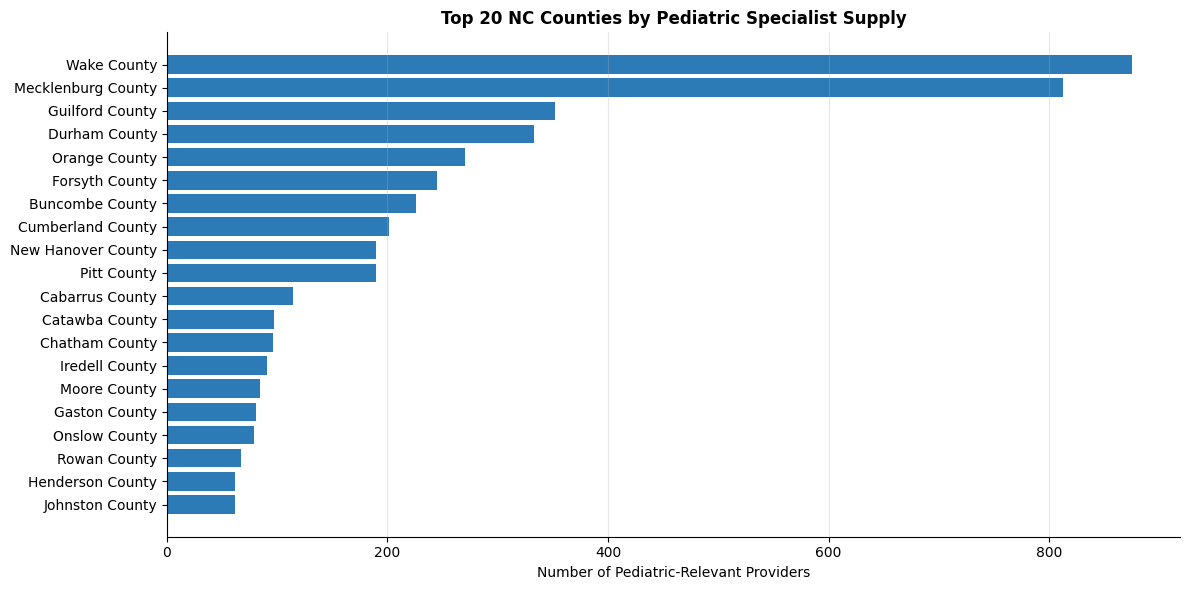

In [ ]:
# --- Cell 11: Quick validation — bar chart ---

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

top_20 = df_supply_wide.nlargest(20, 'total_pediatric_providers')
ax.barh(top_20['county_name'], top_20['total_pediatric_providers'], color='#2c7bb6')
ax.set_xlabel('Number of Pediatric-Relevant Providers')
ax.set_title('Top 20 NC Counties by Pediatric Specialist Supply', fontweight='bold')
ax.invert_yaxis()
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('nc_provider_supply_top20.png', dpi=150, bbox_inches='tight')
plt.show()

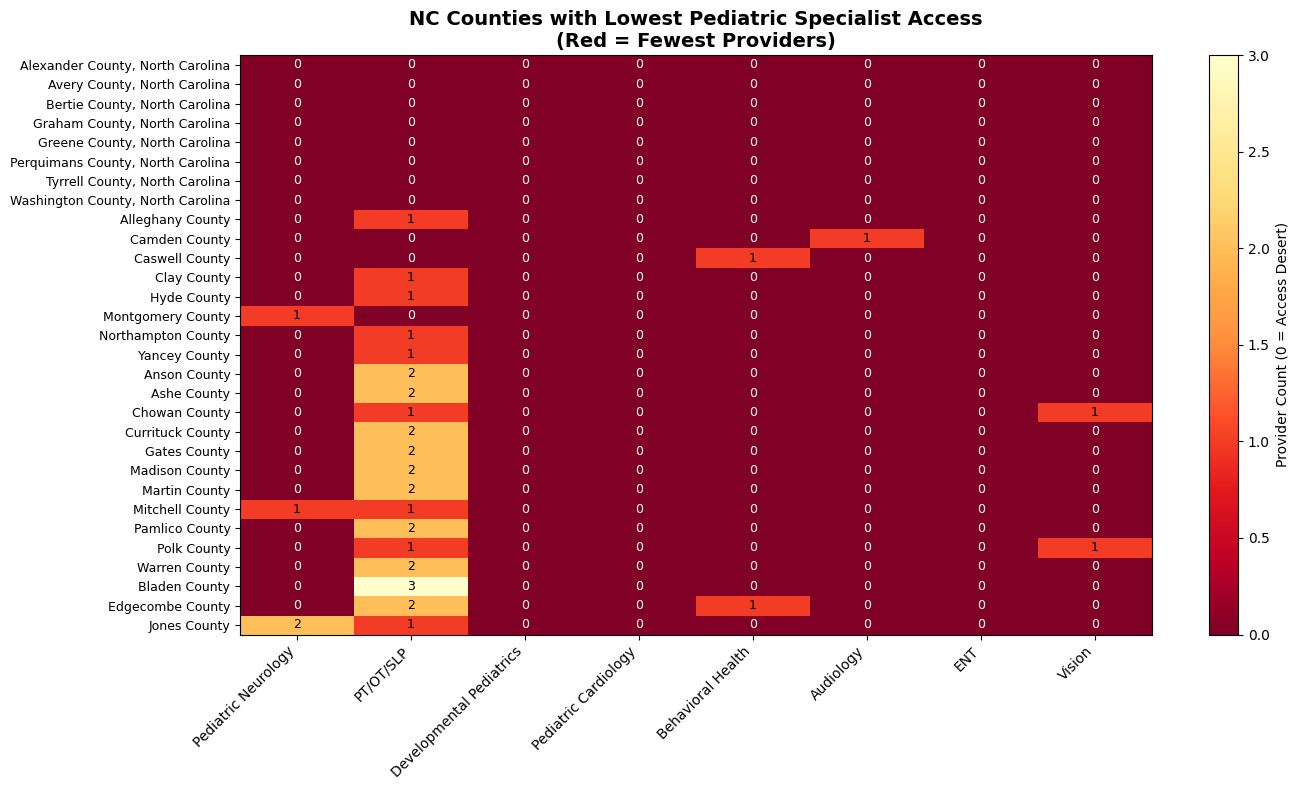

💾 Saved: nc_pediatric_desert_heatmap.png


In [ ]:






# --- Cell 12: Desert specialty heatmap ---

fig, ax = plt.subplots(figsize=(14, 8))

# Show bottom 30 counties (lowest total supply)
bottom_30 = df_supply_wide.nsmallest(30, 'total_pediatric_providers')
heat_data = bottom_30.set_index('county_name')[service_cols]

im = ax.imshow(heat_data.values, cmap='YlOrRd_r', aspect='auto')

ax.set_xticks(range(len(service_cols)))
ax.set_yticks(range(len(heat_data.index)))
ax.set_xticklabels(service_cols, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heat_data.index, fontsize=9)

# Add values
for i in range(len(heat_data.index)):
    for j in range(len(service_cols)):
        val = heat_data.iloc[i, j]
        color = 'white' if val == 0 else 'black'
        ax.text(j, i, str(int(val)), ha='center', va='center', fontsize=9, color=color)

plt.colorbar(im, ax=ax, label='Provider Count (0 = Access Desert)')
ax.set_title('NC Counties with Lowest Pediatric Specialist Access\n(Red = Fewest Providers)',
             fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('nc_pediatric_desert_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 Saved: nc_pediatric_desert_heatmap.png")

### Statewide Access Maps

**Map 1 (Choropleth)** shows total pediatric specialist supply by county. The contrast between urban centers and the rest of the state is stark. It is a handful of green islands in a sea of red.

**Map 2 (Pediatric Neurology)** answers a simple yes/no question for each county: does a single pediatric neurologist practice here? For the specialties listed in pediatric referral pathways, this binary framing is often more actionable than a gradient because a county either has local access or it doesn't.


⏳ Downloading county shapefiles...
✅ Merged: 100 NC counties


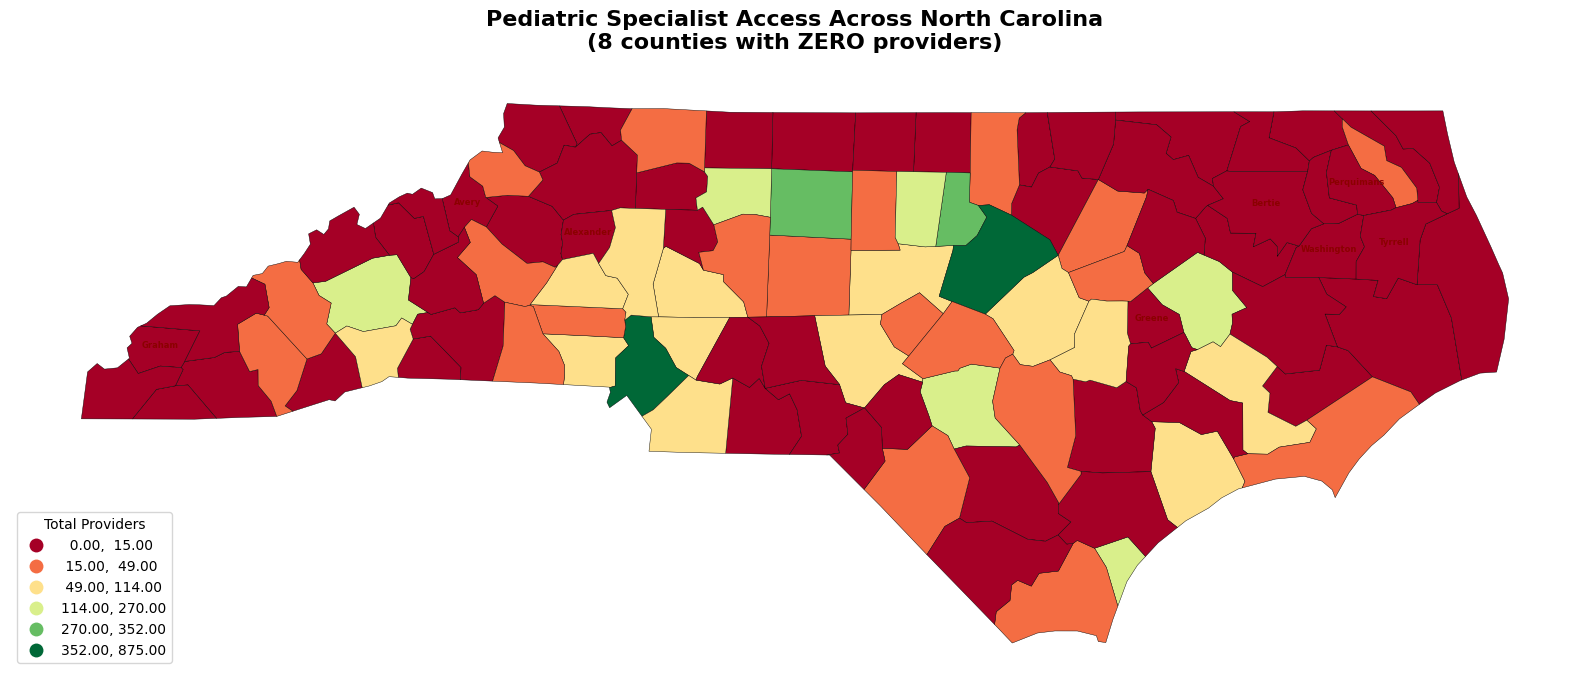

💾 Saved: nc_pediatric_access_map.png


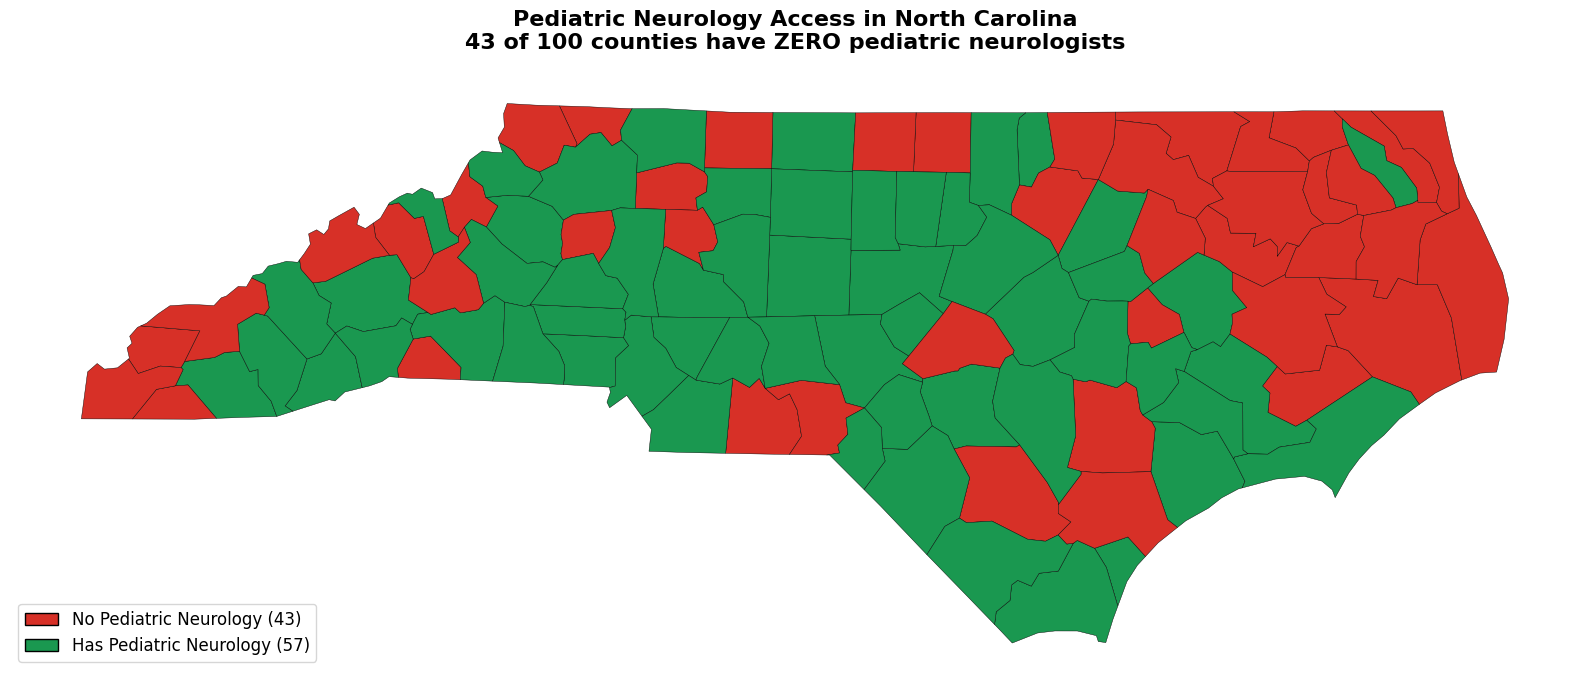

💾 Saved: nc_pediatric_neurology_map.png


In [ ]:
# --- Cell 13: NC Pediatric Access Choropleth Map ---

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load NC county shapefiles
COUNTIES_URL = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_20m.zip"
print("⏳ Downloading county shapefiles...")
gdf = gpd.read_file(COUNTIES_URL)

# Filter to NC (state FIPS 37)
gdf_nc = gdf[gdf['STATEFP'] == '37'].copy()
gdf_nc['county_fips'] = gdf_nc['STATEFP'] + gdf_nc['COUNTYFP']

# Ensure county_fips is string in both
df_supply_wide['county_fips'] = df_supply_wide['county_fips'].astype(str).str.zfill(5)
gdf_nc['county_fips'] = gdf_nc['county_fips'].astype(str).str.zfill(5)

# Merge supply data with geometries
gdf_nc = gdf_nc.merge(df_supply_wide, on='county_fips', how='left')
gdf_nc['total_pediatric_providers'] = gdf_nc['total_pediatric_providers'].fillna(0)

print(f"✅ Merged: {len(gdf_nc)} NC counties")

# --- Map 1: Total pediatric provider supply ---

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

gdf_nc.plot(
    column='total_pediatric_providers',
    cmap='RdYlGn',
    scheme='natural_breaks',
    k=6,
    legend=True,
    legend_kwds={'title': 'Total Providers', 'loc': 'lower left', 'fontsize': 10},
    ax=ax,
    edgecolor='black',
    linewidth=0.3,
    missing_kwds={'color': 'lightgray'}
)

# Label zero-provider counties
zero = gdf_nc[gdf_nc['total_pediatric_providers'] == 0]
for _, row in zero.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(row['county_name'].replace(' County', '').replace(', North Carolina', ''),
                xy=(centroid.x, centroid.y),
                fontsize=6, ha='center', color='darkred', fontweight='bold')

ax.set_title('Pediatric Specialist Access Across North Carolina\n'
             f'({int(gdf_nc["total_pediatric_providers"].eq(0).sum())} counties with ZERO providers)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('nc_pediatric_access_map.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: nc_pediatric_access_map.png")

# --- Map 2: Pediatric Neurology specifically ---

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Binary: has neurology vs doesn't
neuro_col = 'Pediatric Neurology' if 'Pediatric Neurology' in gdf_nc.columns else None
if neuro_col:
    gdf_nc['has_neuro'] = (gdf_nc[neuro_col] > 0).astype(int)

    colors = ['#d73027', '#1a9850']  # red = no, green = yes
    cmap = mcolors.ListedColormap(colors)

    gdf_nc.plot(
        column='has_neuro',
        cmap=cmap,
        ax=ax,
        edgecolor='black',
        linewidth=0.3,
    )

    n_without = (gdf_nc['has_neuro'] == 0).sum()
    n_with = (gdf_nc['has_neuro'] == 1).sum()

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#d73027', edgecolor='black', label=f'No Pediatric Neurology ({n_without})'),
        Patch(facecolor='#1a9850', edgecolor='black', label=f'Has Pediatric Neurology ({n_with})')
    ]
    ax.legend(handles=legend_elements, loc='lower left', fontsize=12)

    ax.set_title(f'Pediatric Neurology Access in North Carolina\n'
                 f'{n_without} of 100 counties have ZERO pediatric neurologists',
                 fontsize=16, fontweight='bold', pad=20)

ax.set_axis_off()
plt.tight_layout()
plt.savefig('nc_pediatric_neurology_map.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: nc_pediatric_neurology_map.png")

---
## Step 2: Pediatric Demand

Provider counts alone don't tell the full story. A county with 5 providers serving 2,000 children is in a fundamentally different position than a county with 5 providers serving 50,000. We need the demand side: how many children live in each county, and how many face the additional barrier of poverty?


In [ ]:
# ============================================================
# Step 2: Pediatric Demand — Child Population & Medicaid
# ============================================================

# --- Cell 14: Pull child population from Census ACS ---

print("⏳ Fetching child population data from Census ACS...")

# ACS 5-Year, 2022
# B09001_001E = Population under 18 years
# B01003_001E = Total population
# B27010_017E = Uninsured children under 19

CENSUS_URL = "https://api.census.gov/data/2022/acs/acs5"

resp = requests.get(CENSUS_URL, params={
    'get': 'NAME,B09001_001E,B01003_001E',
    'for': 'county:*',
    'in': 'state:37'
}, timeout=60)
resp.raise_for_status()

data = resp.json()
df_demand = pd.DataFrame(data[1:], columns=data[0])

df_demand['county_fips'] = df_demand['state'] + df_demand['county']
df_demand['child_pop'] = pd.to_numeric(df_demand['B09001_001E'], errors='coerce')
df_demand['total_pop'] = pd.to_numeric(df_demand['B01003_001E'], errors='coerce')
df_demand['pct_children'] = (df_demand['child_pop'] / df_demand['total_pop'] * 100).round(1)

print(f"✅ Child population data: {len(df_demand)} NC counties")
print(f"   Total children in NC: {df_demand['child_pop'].sum():,}")
print(f"   Avg % children: {df_demand['pct_children'].mean():.1f}%")

print(f"\n=== TOP 10 COUNTIES BY CHILD POPULATION ===")
print(df_demand.nlargest(10, 'child_pop')[['NAME', 'child_pop', 'total_pop', 'pct_children']].to_string(index=False))

⏳ Fetching child population data from Census ACS...
✅ Child population data: 100 NC counties
   Total children in NC: 2,283,888
   Avg % children: 20.4%

=== TOP 10 COUNTIES BY CHILD POPULATION ===
                              NAME  child_pop  total_pop  pct_children
       Wake County, North Carolina     264406    1132103          23.4
Mecklenburg County, North Carolina     256136    1115403          23.0
   Guilford County, North Carolina     118288     539557          21.9
    Forsyth County, North Carolina      86954     383739          22.7
 Cumberland County, North Carolina      83590     335207          24.9
     Durham County, North Carolina      65125     325101          20.0
      Union County, North Carolina      62486     240109          26.0
   Cabarrus County, North Carolina      57072     226396          25.2
   Johnston County, North Carolina      54580     219042          24.9
     Gaston County, North Carolina      51134     228972          22.3


### Child Poverty

Poverty compounds access barriers. A family in poverty is less likely to have reliable transportation, flexible work schedules, or the ability to absorb the indirect costs of traveling to a distant specialist. The child poverty rate contextualizes our access ratios. A county with a high children-per-provider ratio AND high poverty is in a qualitatively worse position.


In [ ]:


# --- Cell 15: Pull poverty data for children ---

print("\n⏳ Fetching child poverty data...")

# B17001_004E + B17001_018E = Children under 6 below poverty (male + female)
# B17001_005E + B17001_019E = Children 6-11 below poverty
# B17001_006E + B17001_020E = Children 12-17 below poverty
# Simpler: use B17006 — poverty status of related children under 18

resp2 = requests.get(CENSUS_URL, params={
    'get': 'NAME,B17006_002E,B17006_001E',
    'for': 'county:*',
    'in': 'state:37'
}, timeout=60)
resp2.raise_for_status()

data2 = resp2.json()
df_poverty = pd.DataFrame(data2[1:], columns=data2[0])
df_poverty['county_fips'] = df_poverty['state'] + df_poverty['county']
df_poverty['children_in_poverty'] = pd.to_numeric(df_poverty['B17006_002E'], errors='coerce')
df_poverty['children_poverty_universe'] = pd.to_numeric(df_poverty['B17006_001E'], errors='coerce')
df_poverty['child_poverty_rate'] = (
    df_poverty['children_in_poverty'] / df_poverty['children_poverty_universe'] * 100
).round(1)

df_demand = df_demand.merge(
    df_poverty[['county_fips', 'children_in_poverty', 'child_poverty_rate']],
    on='county_fips', how='left'
)

print(f"✅ Child poverty data merged")
print(f"   NC average child poverty rate: {df_demand['child_poverty_rate'].mean():.1f}%")


⏳ Fetching child poverty data...
✅ Child poverty data merged
   NC average child poverty rate: 22.0%


### Merging Supply and Demand

We join provider supply data with child population and poverty data on county FIPS codes. After this merge, each of NC's 100 counties has a complete profile: how many children live there, how many are in poverty, and how many pediatric specialists of each type practice there.


In [ ]:

# --- Cell 16: Merge supply + demand ---

print("\n⏳ Merging supply and demand data...")

df_supply_wide['county_fips'] = df_supply_wide['county_fips'].astype(str).str.zfill(5)
df_demand['county_fips'] = df_demand['county_fips'].astype(str).str.zfill(5)

df_access = df_demand.merge(df_supply_wide, on='county_fips', how='left')

# Fill missing provider counts with 0
service_cols = list(SERVICE_CATEGORIES.keys())
for col in service_cols:
    if col in df_access.columns:
        df_access[col] = df_access[col].fillna(0).astype(int)
if 'total_pediatric_providers' in df_access.columns:
    df_access['total_pediatric_providers'] = df_access['total_pediatric_providers'].fillna(0).astype(int)

print(f"✅ Merged dataset: {len(df_access)} counties")


⏳ Merging supply and demand data...
✅ Merged dataset: 100 counties


### Access Ratios and Desert Classification

The **children-per-provider ratio** is the core metric: for every pediatric specialist in this county, how many children are competing for their time?

We classify counties into access levels:
- **Well-Served:** ≤50 children per provider
- **Adequate:** 51–150
- **Underserved:** 151–500
- **Severe Desert:** >500
- **No Providers:** Zero pediatric specialists of any kind

Counties with zero providers are designated separately because their ratio is functionally infinite, no amount of demand management improves access when supply is zero. These are the counties where the only solution is connecting families to providers elsewhere. That is precisely what access infrastructure does.


In [ ]:

# --- Cell 17: Calculate access ratios ---

print("\n📊 CALCULATING ACCESS RATIOS...")

# Children per provider (lower = better access)
df_access['children_per_provider'] = np.where(
    df_access['total_pediatric_providers'] > 0,
    (df_access['child_pop'] / df_access['total_pediatric_providers']).round(0),
    np.nan  # Infinite ratio for zero-provider counties
)

# Specialty-specific ratios
for cat in service_cols:
    if cat in df_access.columns:
        col_name = f'children_per_{cat.lower().replace("/","_").replace(" ","_")}'
        df_access[col_name] = np.where(
            df_access[cat] > 0,
            (df_access['child_pop'] / df_access[cat]).round(0),
            np.nan
        )

# Flag access desert levels
df_access['access_level'] = pd.cut(
    df_access['children_per_provider'],
    bins=[0, 50, 150, 500, float('inf')],
    labels=['Well-Served', 'Adequate', 'Underserved', 'Severe Desert'],
    right=True
)

# Counties with zero providers get worst designation
df_access['access_level'] = df_access['access_level'].cat.add_categories('No Providers')
df_access.loc[df_access['total_pediatric_providers'] == 0, 'access_level'] = 'No Providers'

print(f"\n=== ACCESS LEVELS ===")
print(df_access['access_level'].value_counts().to_string())

print(f"\n=== WORST ACCESS RATIOS (children per provider) ===")
worst = df_access[df_access['children_per_provider'].notna()].nlargest(15, 'children_per_provider')
print(worst[['NAME_x', 'child_pop', 'total_pediatric_providers', 'children_per_provider']].to_string(index=False))

print(f"\n=== ZERO-PROVIDER COUNTIES (with child population) ===")
zero = df_access[df_access['total_pediatric_providers'] == 0].sort_values('child_pop', ascending=False)
print(zero[['NAME_x', 'child_pop', 'child_poverty_rate']].to_string(index=False))


📊 CALCULATING ACCESS RATIOS...

=== ACCESS LEVELS ===
access_level
Severe Desert    67
Underserved      24
No Providers      8
Adequate          1
Well-Served       0

=== WORST ACCESS RATIOS (children per provider) ===
                            NAME_x  child_pop  total_pediatric_providers  children_per_provider
 Montgomery County, North Carolina       5486                          1                 5486.0
    Caswell County, North Carolina       4115                          1                 4115.0
  Edgecombe County, North Carolina      11123                          3                 3708.0
     Yancey County, North Carolina       3423                          1                 3423.0
  Currituck County, North Carolina       6340                          2                 3170.0
Northampton County, North Carolina       3086                          1                 3086.0
   Franklin County, North Carolina      15086                          5                 3017.0
     Stokes

### Access Ratio Map

Red counties have the most children competing for the fewest specialists. The darker the red, the wider the gap between referral and care.


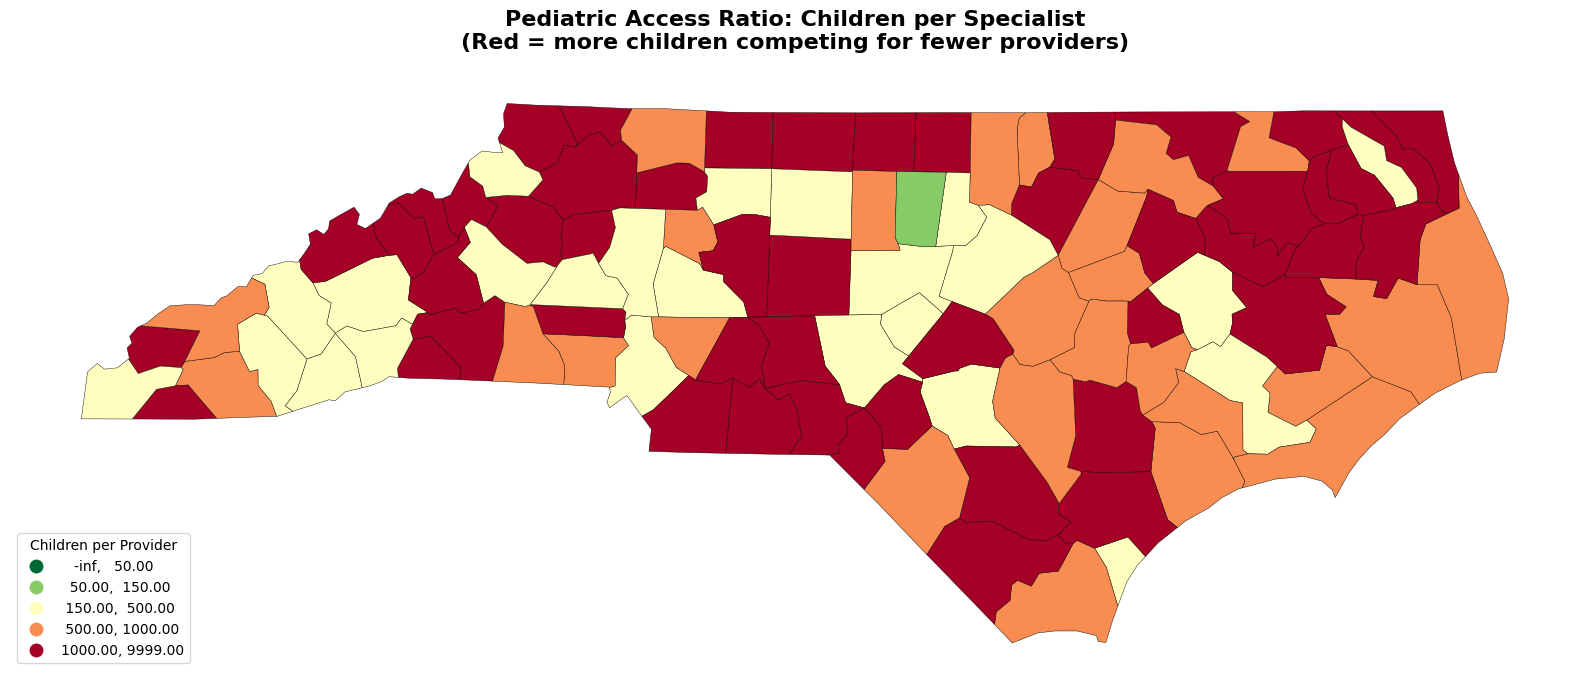

💾 Saved: nc_access_ratio_map.png


In [ ]:
# --- Cell 18: Access ratio choropleth ---

import matplotlib.pyplot as plt

# Merge with geometries
gdf_nc['county_fips'] = gdf_nc['county_fips'].astype(str).str.zfill(5)
gdf_access = gdf_nc[['county_fips', 'geometry']].merge(df_access, on='county_fips', how='left')

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# For mapping: replace NaN (zero providers) with a high number so they show as worst
gdf_access['ratio_for_map'] = gdf_access['children_per_provider'].fillna(9999)

gdf_access.plot(
    column='ratio_for_map',
    cmap='RdYlGn_r',  # reversed: red = high ratio (bad), green = low (good)
    scheme='user_defined',
    classification_kwds={'bins': [50, 150, 500, 1000, 9999]},
    legend=True,
    legend_kwds={'title': 'Children per Provider', 'loc': 'lower left'},
    ax=ax,
    edgecolor='black',
    linewidth=0.3,
)

ax.set_title('Pediatric Access Ratio: Children per Specialist\n'
             '(Red = more children competing for fewer providers)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('nc_access_ratio_map.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: nc_access_ratio_map.png")

In [ ]:


# --- Cell 19: Save full dataset ---

df_access.to_csv('nc_pediatric_access_full.csv', index=False)
print(f"\n💾 Saved: nc_pediatric_access_full.csv")
print(f"   {len(df_access)} counties × {len(df_access.columns)} columns")

print(f"\n{'='*60}")
print(f"🎯 KEY FINDINGS FOR TIME-TO-CARE PITCH")
print(f"{'='*60}")
print(f"Total NC children: {df_access['child_pop'].sum():,}")
print(f"Counties with ZERO pediatric providers: {(df_access['total_pediatric_providers']==0).sum()}")
zero_pop = df_access.loc[df_access['total_pediatric_providers']==0, 'child_pop'].sum()
print(f"Children in zero-provider counties: {zero_pop:,}")
print(f"NC median children-per-provider ratio: {df_access['children_per_provider'].median():.0f}")
print(f"NC average child poverty rate: {df_access['child_poverty_rate'].mean():.1f}%")


💾 Saved: nc_pediatric_access_full.csv
   100 counties × 32 columns

🎯 KEY FINDINGS FOR TIME-TO-CARE PITCH
Total NC children: 2,283,888
Counties with ZERO pediatric providers: 8
Children in zero-provider counties: 23,435
NC median children-per-provider ratio: 890
NC average child poverty rate: 22.0%


In [ ]:
from google.colab import files
import shutil
import os

project = 'nc-pediatric-access-pipeline'
os.makedirs(f'{project}/figures', exist_ok=True)
os.makedirs(f'{project}/data', exist_ok=True)
os.makedirs(f'{project}/maps', exist_ok=True)
os.makedirs(f'{project}/notebooks', exist_ok=True)

# Figures
for f in ['nc_provider_supply_top20.png', 'nc_pediatric_desert_heatmap.png',
          'nc_pediatric_access_map.png', 'nc_pediatric_neurology_map.png',
          'nc_access_ratio_map.png']:
    if os.path.exists(f):
        shutil.copy(f, f'{project}/figures/{f}')

# Data
for f in ['nc_pediatric_providers.csv', 'nc_county_provider_supply.csv',
          'nc_pediatric_access_full.csv']:
    if os.path.exists(f):
        shutil.copy(f, f'{project}/data/{f}')

# Zip and download
shutil.make_archive(project, 'zip', '.', project)
files.download(f'{project}.zip')
print("✅ Downloading project zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloading project zip


---
## Step 3: WNC Pilot Deep Dive

The pilot is designed for Western North Carolina, 18 counties in the Appalachian mountain region. This section provides the operational intelligence the pilot team needs: which specialties are missing where, how many children are affected, and which counties should be prioritized.

WNC contains both the largest pediatric specialist hub west of Charlotte (Buncombe County / Asheville) and some of the most isolated rural communities in the state. The intra-regional disparity is extreme and invisible at the state level.


In [ ]:
# ============================================================
# Step 3: WNC Pilot Deep Dive
# ============================================================

# --- Cell 20: Define WNC pilot region ---

WNC_FIPS = {
    '37021': 'Buncombe', '37089': 'Henderson', '37115': 'Madison',
    '37087': 'Haywood', '37175': 'Transylvania', '37111': 'McDowell',
    '37199': 'Yancey', '37121': 'Mitchell', '37011': 'Avery',
    '37189': 'Watauga', '37099': 'Jackson', '37173': 'Swain',
    '37075': 'Graham', '37039': 'Cherokee', '37113': 'Macon',
    '37161': 'Rutherford', '37149': 'Polk', '37023': 'Burke'
}

df_access['county_fips'] = df_access['county_fips'].astype(str).str.zfill(5)
df_wnc = df_access[df_access['county_fips'].isin(WNC_FIPS.keys())].copy()
df_wnc['county_short'] = df_wnc['county_fips'].map(WNC_FIPS)

print(f"=== WNC PILOT REGION: {len(df_wnc)} COUNTIES ===\n")
print(f"Total children in WNC: {df_wnc['child_pop'].sum():,}")
print(f"Avg child poverty rate: {df_wnc['child_poverty_rate'].mean():.1f}%")
print(f"Total pediatric providers: {df_wnc['total_pediatric_providers'].sum()}")

wnc_ratio = df_wnc['child_pop'].sum() / max(df_wnc['total_pediatric_providers'].sum(), 1)
nc_ratio = df_access['child_pop'].sum() / max(df_access['total_pediatric_providers'].sum(), 1)
print(f"\nWNC children-per-provider ratio: {wnc_ratio:.0f}")
print(f"NC statewide ratio: {nc_ratio:.0f}")

=== WNC PILOT REGION: 18 COUNTIES ===

Total children in WNC: 169,468
Avg child poverty rate: 18.4%
Total pediatric providers: 470

WNC children-per-provider ratio: 361
NC statewide ratio: 413


### WNC Specialty Gap Analysis

For each of the 18 pilot counties, this table shows exactly how many providers exist in each specialty category alongside the child population and poverty rate. The specialty desert counts identify which services are most systematically absent from the region.


In [ ]:


# --- Cell 21: WNC specialty gap table ---

print("\n=== WNC PROVIDER SUPPLY BY COUNTY & SPECIALTY ===\n")

service_cols = list(SERVICE_CATEGORIES.keys())
display_cols = ['county_short', 'child_pop', 'child_poverty_rate'] + service_cols + ['total_pediatric_providers']
print(df_wnc.sort_values('total_pediatric_providers')[display_cols].to_string(index=False))

# Specialty deserts within WNC
print("\n=== WNC SPECIALTY DESERTS ===")
print("(Counties with ZERO providers per specialty)\n")
for cat in service_cols:
    if cat in df_wnc.columns:
        zero_counties = df_wnc[df_wnc[cat] == 0]['county_short'].tolist()
        print(f"  {cat:30s}  {len(zero_counties)}/18 counties missing")
        if len(zero_counties) <= 10:
            print(f"    → {', '.join(sorted(zero_counties))}")


=== WNC PROVIDER SUPPLY BY COUNTY & SPECIALTY ===

county_short  child_pop  child_poverty_rate  Pediatric Neurology  PT/OT/SLP  Developmental Pediatrics  Pediatric Cardiology  Behavioral Health  Audiology  ENT  Vision  total_pediatric_providers
       Avery       2455                11.3                    0          0                         0                     0                  0          0    0       0                          0
      Graham       1637                 9.5                    0          0                         0                     0                  0          0    0       0                          0
      Yancey       3423                23.6                    0          1                         0                     0                  0          0    0       0                          1
     Madison       3777                11.0                    0          2                         0                     0                  0          0    0       0      

### WNC Heatmap

Each cell is a county-specialty combination. Green means providers exist; red means zero. The wall of red across Pediatric Cardiology (17/18 counties), Developmental Pediatrics (14/18), and Behavioral Health (13/18) makes the scope of the problem immediately visible.


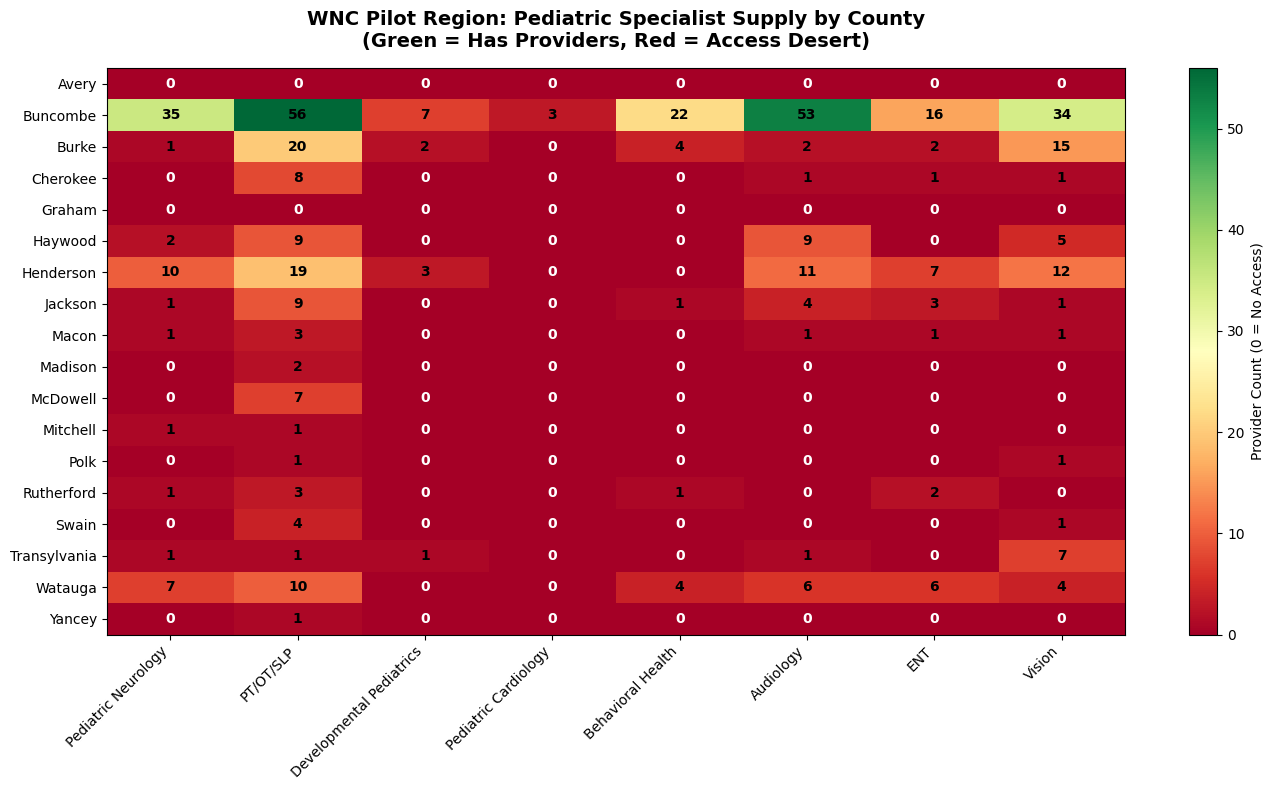

💾 Saved: wnc_pilot_specialty_heatmap.png


In [ ]:


# --- Cell 22: WNC heatmap ---

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))

heat_data = df_wnc.set_index('county_short')[service_cols].sort_index()

im = ax.imshow(heat_data.values, cmap='RdYlGn', aspect='auto')

ax.set_xticks(range(len(service_cols)))
ax.set_yticks(range(len(heat_data.index)))
ax.set_xticklabels(service_cols, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heat_data.index, fontsize=10)

for i in range(len(heat_data.index)):
    for j in range(len(service_cols)):
        val = heat_data.iloc[i, j]
        color = 'white' if val == 0 else 'black'
        ax.text(j, i, str(int(val)), ha='center', va='center', fontsize=10,
                color=color, fontweight='bold')

plt.colorbar(im, ax=ax, label='Provider Count (0 = No Access)')
ax.set_title('WNC Pilot Region: Pediatric Specialist Supply by County\n'
             '(Green = Has Providers, Red = Access Desert)',
             fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('wnc_pilot_specialty_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: wnc_pilot_specialty_heatmap.png")

### WNC Access Overview

The left chart pairs demand (how many children) with a visual flag for zero-provider counties. The right chart shows the children-per-provider ratio with the NC average as a benchmark. Counties to the right of that line are worse than a state average that is itself already classified as severely inadequate.


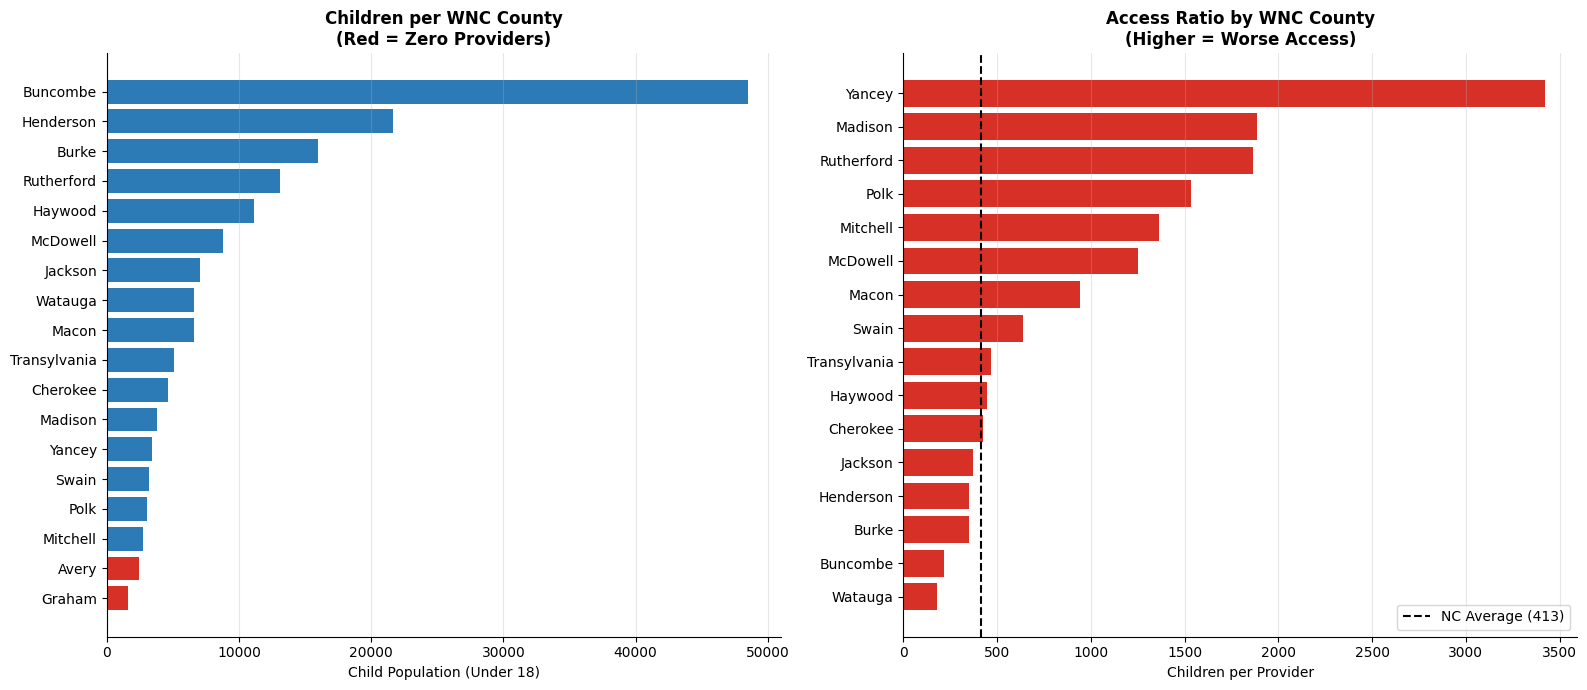

💾 Saved: wnc_pilot_access_overview.png


In [ ]:


# --- Cell 23: WNC comparison bar chart ---

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: child population by county
ax1 = axes[0]
wnc_sorted = df_wnc.sort_values('child_pop')
colors = ['#d73027' if x == 0 else '#2c7bb6' for x in wnc_sorted['total_pediatric_providers']]
ax1.barh(wnc_sorted['county_short'], wnc_sorted['child_pop'], color=colors)
ax1.set_xlabel('Child Population (Under 18)')
ax1.set_title('Children per WNC County\n(Red = Zero Providers)', fontweight='bold')
ax1.spines[['top', 'right']].set_visible(False)
ax1.grid(axis='x', alpha=0.3)

# Right: children per provider ratio
ax2 = axes[1]
wnc_with = df_wnc[df_wnc['children_per_provider'].notna()].sort_values('children_per_provider')
ax2.barh(wnc_with['county_short'], wnc_with['children_per_provider'], color='#d73027')
ax2.axvline(x=nc_ratio, color='black', linestyle='--', label=f'NC Average ({nc_ratio:.0f})')
ax2.set_xlabel('Children per Provider')
ax2.set_title('Access Ratio by WNC County\n(Higher = Worse Access)', fontweight='bold')
ax2.legend()
ax2.spines[['top', 'right']].set_visible(False)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('wnc_pilot_access_overview.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: wnc_pilot_access_overview.png")

### WNC Regional Map

The pilot region colored by access ratio, with each county labeled. Graham and Avery appear in the darkest red. They are the only two WNC counties with zero providers of any kind.


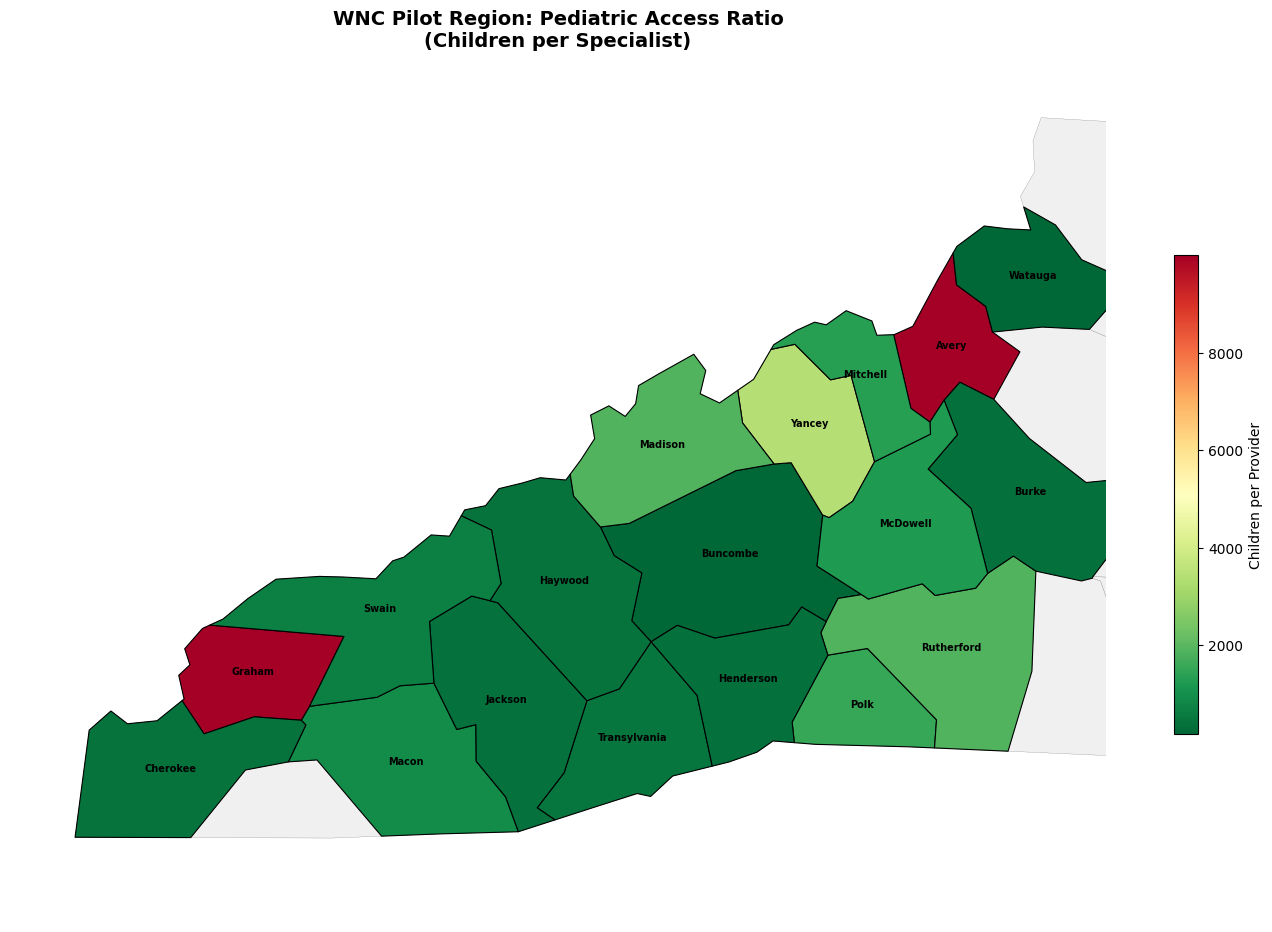

💾 Saved: wnc_pilot_map.png


In [ ]:

# --- Cell 24: WNC zoomed map ---

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# All NC light gray
gdf_nc_full = gdf_nc.copy()
gdf_nc_full.plot(ax=ax, color='#f0f0f0', edgecolor='gray', linewidth=0.2)

# WNC counties colored by access ratio
gdf_wnc = gdf_access[gdf_access['county_fips'].isin(WNC_FIPS.keys())].copy()

gdf_wnc.plot(
    column='ratio_for_map',
    cmap='RdYlGn_r',
    ax=ax,
    edgecolor='black',
    linewidth=0.8,
    legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Children per Provider'}
)

# Label each WNC county
for _, row in gdf_wnc.iterrows():
    centroid = row.geometry.centroid
    name = WNC_FIPS.get(row['county_fips'], '')
    ax.annotate(name, xy=(centroid.x, centroid.y),
                fontsize=7, ha='center', fontweight='bold')

ax.set_xlim(-84.5, -81.5)
ax.set_ylim(34.8, 36.7)
ax.set_title('WNC Pilot Region: Pediatric Access Ratio\n(Children per Specialist)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('wnc_pilot_map.png', dpi=200, bbox_inches='tight')
plt.show()
print("💾 Saved: wnc_pilot_map.png")

WNC Key Findings

A consolidated summary of the pilot region's access landscape.

In [ ]:

# --- Cell 25: WNC key findings ---

print("=" * 60)
print("📍 WNC PILOT REGION — KEY FINDINGS")
print("=" * 60)

zero_wnc = df_wnc[df_wnc['total_pediatric_providers'] == 0]
print(f"\nWNC children: {df_wnc['child_pop'].sum():,}")
print(f"WNC providers: {df_wnc['total_pediatric_providers'].sum()}")
print(f"WNC children-per-provider: {wnc_ratio:.0f} (NC avg: {nc_ratio:.0f})")
print(f"Counties with ZERO providers: {len(zero_wnc)} — {', '.join(zero_wnc['county_short'].tolist())}")
print(f"Children in zero-provider WNC counties: {zero_wnc['child_pop'].sum():,}")

print(f"\nSpecialty gaps (counties with zero):")
for cat in service_cols:
    if cat in df_wnc.columns:
        n = (df_wnc[cat] == 0).sum()
        print(f"  {cat:30s}  {n}/18 counties")

print(f"\nHighest-need WNC counties (most children, fewest providers):")
for _, row in df_wnc.nlargest(5, 'children_per_provider').iterrows():
    if pd.notna(row.get('children_per_provider')):
        print(f"  🔴 {row['county_short']}: {int(row['child_pop']):,} children, "
              f"{int(row['total_pediatric_providers'])} providers, "
              f"ratio {int(row['children_per_provider'])}:1")

📍 WNC PILOT REGION — KEY FINDINGS

WNC children: 169,468
WNC providers: 470
WNC children-per-provider: 361 (NC avg: 413)
Counties with ZERO providers: 2 — Avery, Graham
Children in zero-provider WNC counties: 4,092

Specialty gaps (counties with zero):
  Pediatric Neurology             8/18 counties
  PT/OT/SLP                       2/18 counties
  Developmental Pediatrics        14/18 counties
  Pediatric Cardiology            17/18 counties
  Behavioral Health               13/18 counties
  Audiology                       9/18 counties
  ENT                             10/18 counties
  Vision                          7/18 counties

Highest-need WNC counties (most children, fewest providers):
  🔴 Yancey: 3,423 children, 1 providers, ratio 3423:1
  🔴 Madison: 3,777 children, 2 providers, ratio 1888:1
  🔴 Rutherford: 13,072 children, 7 providers, ratio 1867:1
  🔴 Polk: 3,070 children, 2 providers, ratio 1535:1
  🔴 Mitchell: 2,722 children, 2 providers, ratio 1361:1


---
## Step 4: Interactive Map

Static maps communicate findings in presentations. Interactive maps let stakeholders explore the data themselves. This Folium map renders all 100 NC counties with hover tooltips showing child population, poverty rate, total providers, children-per-provider ratio, and provider counts for each specialty.

The WNC pilot region is outlined in blue dashed lines. The resulting HTML file can be shared as a standalone webpage, no server required, just open in a browser.


In [ ]:




# ============================================================
# Step 4: Interactive Folium Map
# ============================================================

# --- Cell 26: Build interactive map ---

import folium
from folium.features import GeoJsonTooltip

print("\n⏳ Building interactive map...")

# Prepare data
gdf_map = gdf_access.copy()
gdf_map = gdf_map.to_crs(epsg=4326)
gdf_map['geometry'] = gdf_map['geometry'].simplify(0.005, preserve_topology=True)

# Round values for clean tooltips
for col in service_cols + ['child_pop', 'total_pediatric_providers', 'child_poverty_rate']:
    if col in gdf_map.columns:
        gdf_map[col] = pd.to_numeric(gdf_map[col], errors='coerce')

gdf_map['children_per_provider_display'] = gdf_map['children_per_provider'].fillna(0).astype(int)
gdf_map.loc[gdf_map['total_pediatric_providers'] == 0, 'children_per_provider_display'] = 'No Providers'

# Add clean county name for tooltip
gdf_map['county_label'] = gdf_map['NAME_x'].str.replace(', North Carolina', '')

# Create map centered on NC
m = folium.Map(location=[35.5, -79.8], zoom_start=7, tiles='CartoDB positron')

# Choropleth layer
folium.Choropleth(
    geo_data=gdf_map[['county_fips', 'geometry']].__geo_interface__,
    data=gdf_map,
    columns=['county_fips', 'ratio_for_map'],
    key_on='feature.properties.county_fips',
    fill_color='RdYlGn_r',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Children per Pediatric Specialist',
    nan_fill_color='darkred'
).add_to(m)

# Tooltip layer with all the key info
tooltip_cols = ['county_label', 'child_pop', 'child_poverty_rate',
                'total_pediatric_providers', 'children_per_provider_display']
tooltip_aliases = ['County:', 'Children (Under 18):', 'Child Poverty Rate %:',
                   'Total Pediatric Providers:', 'Children per Provider:']

# Add specialty columns to tooltip
for cat in service_cols:
    if cat in gdf_map.columns:
        gdf_map[cat] = gdf_map[cat].fillna(0).astype(int)
        tooltip_cols.append(cat)
        tooltip_aliases.append(f'{cat}:')

folium.GeoJson(
    gdf_map[tooltip_cols + ['geometry']],
    style_function=lambda x: {'fillOpacity': 0, 'weight': 0},
    tooltip=GeoJsonTooltip(fields=tooltip_cols, aliases=tooltip_aliases, sticky=True)
).add_to(m)

# Highlight WNC pilot region with thicker borders
gdf_wnc_map = gdf_map[gdf_map['county_fips'].isin(WNC_FIPS.keys())]
folium.GeoJson(
    gdf_wnc_map[['geometry']],
    style_function=lambda x: {
        'fillOpacity': 0, 'weight': 3, 'color': 'blue', 'dashArray': '5,5'
    },
    name='WNC Pilot Region'
).add_to(m)

folium.LayerControl().add_to(m)

m.save('nc_pediatric_access_interactive.html')
print("💾 Saved: nc_pediatric_access_interactive.html")
print("   Open in browser — hover over any county to see full details")
print("   Blue dashed outline = WNC pilot region")
m


⏳ Building interactive map...
💾 Saved: nc_pediatric_access_interactive.html
   Open in browser — hover over any county to see full details
   Blue dashed outline = WNC pilot region


In [ ]:
from google.colab import files
import shutil
import os

# Add new files to the project folder
project = 'nc-pediatric-access-pipeline'

for f in ['wnc_pilot_specialty_heatmap.png', 'wnc_pilot_access_overview.png', 'wnc_pilot_map.png']:
    if os.path.exists(f):
        shutil.copy(f, f'{project}/figures/{f}')

if os.path.exists('nc_pediatric_access_interactive.html'):
    shutil.copy('nc_pediatric_access_interactive.html', f'{project}/maps/nc_pediatric_access_interactive.html')

if os.path.exists('nc_pediatric_access_full.csv'):
    shutil.copy('nc_pediatric_access_full.csv', f'{project}/data/nc_pediatric_access_full.csv')

# Re-zip and download
shutil.make_archive(project, 'zip', '.', project)
files.download(f'{project}.zip')
print("✅ Downloading updated project zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloading updated project zip
